In [1]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

In [3]:
#data
pm25 = pd.read_csv("20180901_20200112_PM2.5_AQMesh_Scaled_Dataset_UGM3.csv")
no2 = pd.read_csv("20180901_20200112_NO2_AQMesh_Scaled_Dataset_UGM3.csv")

In [4]:
#meta data
pm25_meta = pd.read_csv("20180901_20200112_PM2.5_site_metadata.csv")
no2_meta = pd.read_csv("20180901_20200112_NO2_site_metadata.csv")

In [5]:
#info data
pm25_info = pd.read_csv("20180901_20200112_PM2.5_site_info.csv")
no2_info = pd.read_csv("20180901_20200112_NO2_site_info.csv")

In [6]:
meta_concat = no2_meta[~no2_meta['pod_id_location'].isin(pm25_meta['pod_id_location'])]

In [7]:
frames_meta = [pm25_meta, meta_concat]
meta_pm_no = pd.concat(frames_meta).reset_index()

In [8]:
info_concat = no2_info[~no2_info['pod_id_location'].isin(pm25_info['pod_id_location'])]

In [9]:
frames = [pm25_info, info_concat]
info_pm_no = pd.concat(frames).reset_index()

In [10]:
#removing null from both dataframes and dropping 
pm25 = pm25.loc[pm25['pm2_5_ugm3'] != -999]
no2 = no2.loc[no2['no2_ugm3'] != -999]

pm25 = pm25.drop(columns=['ratification_status'])
no2 = no2.drop(columns=['ratification_status'])

In [11]:
#removing outliers from measurements 
mean = np.mean(pm25['pm2_5_ugm3'])
std = np.std(pm25['pm2_5_ugm3'])

def z_value(value, mean, std):
    return (value - mean) / std

pm25['z_value'] = z_value(pm25['pm2_5_ugm3'], mean, std)

In [12]:
#removing outliers from measurements 
mean = np.mean(no2['no2_ugm3'])
std = np.std(no2['no2_ugm3'])

def z_value(value, mean, std):
    return (value - mean) / std

no2['z_value'] = z_value(no2['no2_ugm3'], mean, std)

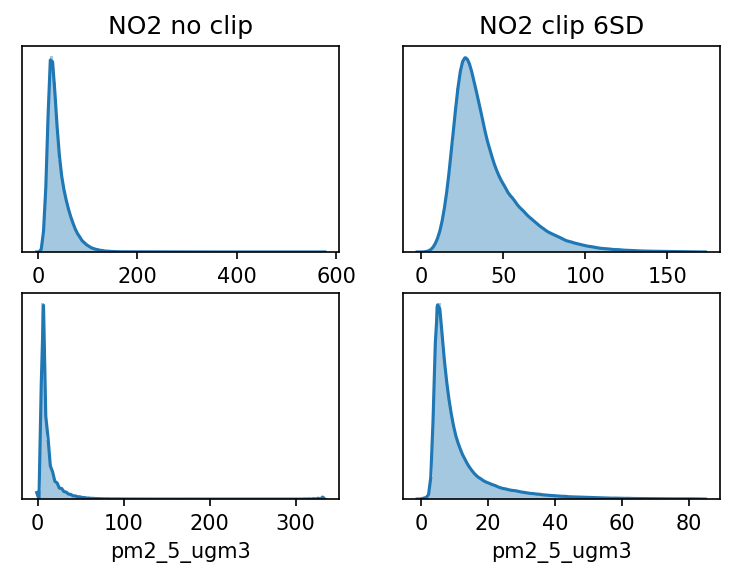

In [13]:
fig, axs = plt.subplots(dpi=150, ncols=2, nrows=2)

sns.distplot(no2['no2_ugm3'],ax=axs[0,0], bins=100).set_title("NO2 no clip")
sns.distplot(no2[no2['z_value'] < 6]['no2_ugm3'], bins = 100, ax=axs[0,1]).set_title("NO2 clip 6SD")
sns.distplot(pm25['pm2_5_ugm3'],ax=axs[1,0], bins=100)
sns.distplot(pm25[pm25['z_value'] < 6]['pm2_5_ugm3'], bins = 100, ax=axs[1,1])

axs[0,1].set_yticks([])
axs[0,0].set_yticks([])
axs[1,0].set_yticks([])
axs[1,1].set_yticks([])

plt.show()

In [14]:
#DONT CLIP DATA####
#pm25 = pm25.loc[pm25['z_value'] <= 6]
#no2 = no2.loc[no2['z_value'] <= 6]

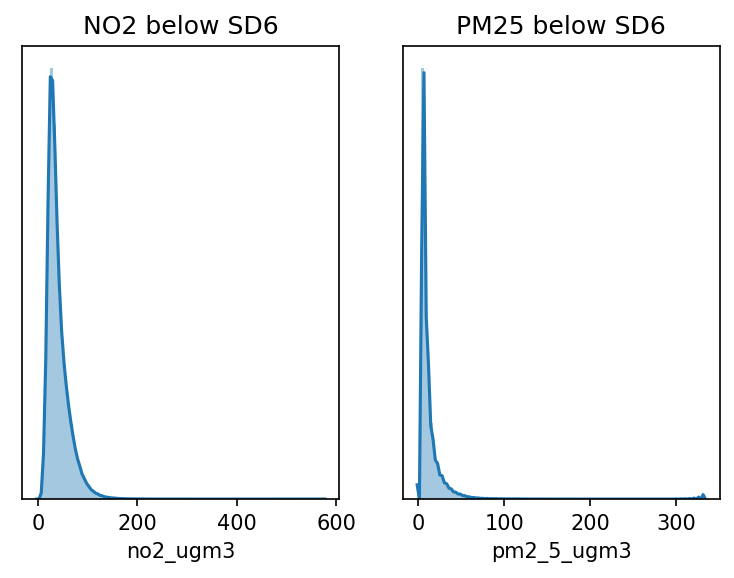

In [15]:
fig, axs = plt.subplots(dpi=150, ncols=2)

sns.distplot(no2['no2_ugm3'],ax=axs[0], bins=100).set_title("NO2 below SD6")
sns.distplot(pm25['pm2_5_ugm3'],ax=axs[1], bins=100).set_title("PM25 below SD6")

axs[0].set_yticks([])
axs[1].set_yticks([])

plt.show()

In [16]:
#merging pm25 and no2
df = pd.merge(pm25, no2, how='outer', on=['pod_id_location', 'date_UTC'])

In [17]:
#removing redun columns and reordering
df = df.drop(['pod_id_x', 'location_name_x','pod_id_y','location_name_y','z_value_x','z_value_y'], axis=1)
df = df[['date_UTC', 'pm2_5_ugm3', 'no2_ugm3', 'pod_id_location']]

In [18]:
#merging meta and info concat into base df
df = pd.merge(df, meta_pm_no, how='left', on='pod_id_location')
df = pd.merge(df, info_pm_no, how='left', on='pod_id_location')

In [19]:
#identifying which features to keep in clean dataset
#for i in df.columns: 
#    print(i)

In [20]:
#creating clean dataset

cols = ['date_UTC',
       'pm2_5_ugm3',
       'no2_ugm3',
       'pod_id_location',
       'location_name_x',
       'Borough_x',
       'Type_x',
       'ULEZ_x',
       'Latitude_x',
       'Longitude_x',
       'X_Coord_x',
       'Y_Coord_x',
       'Site_Type']

df = df[cols]

In [21]:
#importing new ULEZ boundry to dataframe from ULEZ script
ULEZ = pd.read_csv("ulez_sensors.csv", index_col=0)

In [22]:
#merging ULEZ sites to df by pod_id_location
df = pd.merge(df, ULEZ, how='left', on='pod_id_location')

In [23]:
#chnaging values for ULEZ names and replacing NA's with value
df['boundary'] = df['boundary'].replace(['Ultra Low Emission Zone'], 'ULEZ')
df['boundary'] = df['boundary'].fillna("non-ULEZ")
df['Site_Type'] = df['Site_Type'].fillna("Other")
df = df.drop(['ULEZ_x'], axis=1)

In [24]:
#renaming columns to make dataframe cleaner
col_dic = {'location_name_x': 'location_name', 
                'Borough_x': 'borough',
                'Type_x': 'Type',
                'Latitude_x': 'Latitude',
                'Longitude_x': 'Longitude',
                'X_Coord_x': 'x_coord',
                'Y_Coord_x': 'y_coord',
                'boundary': 'Zone'
               }

df = df.rename(columns = col_dic)

In [25]:
#merging total vehicle km from LAEI !!2016!! per borough 
veh_borough = pd.read_csv("total_vehicle_km_borough.csv")

In [26]:
df_borough = df['borough'].unique()
veh_b = veh_borough['borough'].unique()

In [27]:
print(set(df_borough) - set(veh_b))

{'Barking & Dagenham', 'Westminster', 'Hammersmith & Fulham', 'City of London', 'Kensington & Chelsea'}


In [28]:
print(set(veh_b) - set(df_borough))

{'Barking and Dagenham', 'NonGLA', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Croydon', 'City', 'City of Westminster'}


In [29]:
def clean_boroughs(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.replace('Hammersmith and Fulham', 'Hammersmith & Fulham')
    txt = txt.replace('Barking and Dagenham', 'Barking & Dagenham')
    txt = txt.replace('City of Westminster', 'Westminster')
    txt = txt.replace('Kensington and Chelsea', 'Kensington & Chelsea')
    return txt

In [30]:
veh_borough['borough'] = veh_borough['borough'].apply(clean_boroughs)

In [31]:
veh_borough['borough'] = veh_borough['borough'].replace('City', 'City of London')

In [32]:
df = pd.merge(df, veh_borough, how='left', on='borough')

In [33]:
#adding road distances to df

In [34]:
road_dist = pd.read_csv("road_distances.csv", index_col=0)

In [35]:
df = pd.merge(df, road_dist, how='left', on='pod_id_location')

In [36]:
#adding school term times to df, also public holidays and turning date column to datetime format
df['date_UTC'] = pd.to_datetime(df["date_UTC"])

In [37]:
#first create a dictonary for school holiday
#print (pd.to_datetime(df["date_UTC"]).min())
#print (pd.to_datetime(df["date_UTC"]).max())
#we know the first date in our df is 2018-09-20 11:00:00 and max is 2020-01-13 00:00:00
#so we will make a dictionary with dates starting from autumn half term 2018
#source for school holidays.... we are assuming all schools are same https://www.standard.co.uk/lifestyle/school-term-dates-2019-2020-uk-holidays-a4227506.html

school_hols = pd.DataFrame({'Holiday': ['autumn 18', 'winter 18', 'feb 19', 'spring 19', 'summer 19', 'autumn 19', 'winter 19'],
                    'start': pd.to_datetime(['22-10-2018', '24-12-2018','18-02-2019', '08-04-2019', '23-07-2019', '21-10-2019', '21-12-2019'],format='%d-%m-%Y'),
                    'end': pd.to_datetime(['26-10-2018', '06-01-2019', '22-02-2019', '22-04-2019', '01-09-2019', '25-10-2019', '03-01-2020'],format='%d-%m-%Y')})

df['school_hol'] = (pd.concat([df['date_UTC'].between(start, end) for start,end in zip(school_hols.start, school_hols.end)], 1)
                   .any(1)
                   .map({True: 'School Holiday', False: 'Term time'}))

In [38]:
#doing same for public holidays 

public_hol = {
             pd.to_datetime('2018-12-25',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2018-12-26',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-01-01',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-04-19',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-04-22',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-05-06',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-05-27',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-08-26',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-12-25',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2019-12-26',format='%Y-%m-%d'): 'public holiday',
             pd.to_datetime('2020-01-01',format='%Y-%m-%d'): 'public holiday'
}

In [39]:
df['public_hols'] = df['date_UTC'].dt.date.map(public_hol).fillna('non-holiday')

In [40]:
#adding new category for school run, assuming school run is betwee 0700 and 0900
morning_school_run = {
             pd.to_datetime('08:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('09:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('10:00:00',format='%H:%M:%S').hour: 'school run'
}

afternoon_school_run = {
             pd.to_datetime('16:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('17:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('18:00:00',format='%H:%M:%S').hour: 'school run'
}



morning_afternoon_school_run = {
             pd.to_datetime('08:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('09:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('10:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('16:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('17:00:00',format='%H:%M:%S').hour: 'school run',
             pd.to_datetime('18:00:00',format='%H:%M:%S').hour: 'school run'
}

sleeping = {
             pd.to_datetime('23:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('00:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('01:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('02:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('03:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('04:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('05:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('06:00:00',format='%H:%M:%S').hour: 'sleeping',
             pd.to_datetime('07:00:00',format='%H:%M:%S').hour: 'sleeping'
}

In [41]:
df['morning school run'] = df['date_UTC'].dt.hour.map(morning_school_run).fillna('not morning school run')
df['afternoon school run'] = df['date_UTC'].dt.hour.map(afternoon_school_run).fillna('not afternoon school run')
df['school run'] = df['date_UTC'].dt.hour.map(morning_afternoon_school_run).fillna('not school run')
df['awake_asleep'] = df['date_UTC'].dt.hour.map(sleeping).fillna('awake')

In [42]:
#adding more detail on public holidays

public_hol_type = {
             pd.to_datetime('2018-12-25',format='%Y-%m-%d'): 'Christmas',
             pd.to_datetime('2018-12-26',format='%Y-%m-%d'): 'Boxing Day',
             pd.to_datetime('2019-01-01',format='%Y-%m-%d'): 'New Years Day',
             pd.to_datetime('2019-04-19',format='%Y-%m-%d'): 'Easter Friday',
             pd.to_datetime('2019-04-22',format='%Y-%m-%d'): 'Easter Monday',
             pd.to_datetime('2019-05-06',format='%Y-%m-%d'): 'Early May Bank Holiday',
             pd.to_datetime('2019-05-27',format='%Y-%m-%d'): 'Late May Bank Holiday',
             pd.to_datetime('2019-08-26',format='%Y-%m-%d'): 'August Bank Holiday',
             pd.to_datetime('2019-12-25',format='%Y-%m-%d'): 'Christmas',
             pd.to_datetime('2019-12-26',format='%Y-%m-%d'): 'Boxing Day',
             pd.to_datetime('2020-01-01',format='%Y-%m-%d'): 'New Years Day'
}

In [43]:
df['public_hol_type'] = df['date_UTC'].dt.date.map(public_hol_type).fillna('non-holiday')

In [44]:
#adding column for total period average for each sensor location 
df['tot_avg_pm25'] = df.groupby('pod_id_location', as_index=False)['pm2_5_ugm3'].transform('mean') 

In [45]:
#adding column for total period average for each sensor location no2
df['tot_avg_no2'] = df.groupby('pod_id_location', as_index=False)['no2_ugm3'].transform('mean') 

In [46]:
#adding darksky weather data to df
read_df = True

if read_df == True:
    df_meteo = pd.read_csv('darksky_weather_focus.csv')
    df_meteo['time'] = pd.to_datetime(df_meteo['time'])
    
df_meteo = df_meteo.rename(columns={"time": "date_UTC"})

In [47]:
#left merging meteo into df
df = pd.merge(df, df_meteo , how='left', on='date_UTC')

In [48]:
df['windBearing'] = df['windBearing'].fillna(-999).astype(int)

In [49]:
#creating new column splitting wind directtion into meteo segments (16)
#dictionary for compass
compass = {
    range(349, 360) : 'N',
    range(0,11): 'N',
    range(11, 34) : 'NNE',
    range(34, 56) : 'NE',
    range(56, 79) : 'ENE',
    range(79, 101) : 'E',
    range(101, 124) : 'ESE',
    range(124, 146) : 'SE',
    range(146, 169) : 'SSE',
    range(169, 191) : 'S',
    range(191, 214) : 'SSW',
    range(214, 236) : 'SW',
    range(236, 259) : 'WSW',
    range(259, 281) : 'W',
    range(281, 304) : 'WNW',
    range(304, 326) : 'NW',
    range(326, 349) : 'NNW'    
}

In [50]:
#unpacking dictionary to create a dataframe containing all 360 degrees of compass 
df_dict = {}

for k,v in compass.items():
    for item in k:
        df_dict[int(item)] = v

wind_df = pd.DataFrame.from_dict(df_dict,orient='index').reset_index()
wind_df.columns=['windBearing', 'compass']

df = pd.merge(df,wind_df,on=['windBearing'],how='left')

In [51]:
#df.isna().sum()
#bool1 = pd.isnull(df['compass'])
#df[bool1].sample(100)

In [52]:
#importing pod lsoa location data
lsoa_loc = pd.read_csv("lsoa_pod_loc.csv")
lsoa_loc = lsoa_loc[['LSOA11CD', 'pod_id_location']]
df = pd.merge(df,lsoa_loc , how='left', on='pod_id_location')

In [53]:
#importing demographic data 
demo = pd.read_csv("id2019.csv")

In [54]:
cols = ['LSOA code (2011)',
       'Index of Multiple Deprivation (IMD) Score',
       'Index of Multiple Deprivation (IMD) Decile (where 1 is most deprived 10% of LSOAs)',
       'Income Decile (where 1 is most deprived 10% of LSOAs)',
       'Employment Decile (where 1 is most deprived 10% of LSOAs)',
       'Education, Skills and Training Decile (where 1 is most deprived 10% of LSOAs)',
       'Health Deprivation and Disability Decile (where 1 is most deprived 10% of LSOAs)',
       'Crime Decile (where 1 is most deprived 10% of LSOAs)',
       'Living Environment Decile (where 1 is most deprived 10% of LSOAs)']

demo = demo[cols]

In [55]:
demo = demo.rename(columns={"LSOA code (2011)": "LSOA11CD"})
df = pd.merge(df, demo, how='left', on='LSOA11CD')

In [56]:
#adding weekday datetime info
weekend = ['Saturday', 'Sunday'] 

df['w_day'] = df['date_UTC'].dt.day_name()
df['hour'] = df['date_UTC'].dt.hour
df['month_number'] = df['date_UTC'].dt.month
df['month'] = df['date_UTC'].dt.month_name()
df['day_type'] = np.where(df['w_day'].isin(weekend), 'weekend', 'weekday')


In [57]:
#df.isna().sum()
#bool1 = pd.isnull(df['compass'])
#df[bool1].sample(100)

In [58]:
df['date_offset'] = (df.date_UTC.dt.month*100 + df.date_UTC.dt.day - 320)%1300

df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['Spring', 'Summer', 'Autumn', 'Winter'])

In [59]:
#new column for just roadside and background readings (there was a whitespace in some of the urban background fields)
background = ['Urban Background', 'Urban Background ']

df['sensor_position'] = np.where(df['Type'].isin(background), 'background', 'roadside/kerbside')

Importing london atlas data 

In [60]:
atlas = pd.read_csv('/Users/oliverpaul/Data_Science/EDF/to_merge/london_borough_atlas.csv')

In [61]:
atlas = atlas[['Borough', 
              'b_Population estimate 2014', 
              'b_Workday Population (excludes tourists) (2014)', 
              'b_General Fertility Rate (GFR) 2015',
              'b_Percentage area greenspace',
              'b_Percentage area road',
              'b_Percentage area domestic gardens ',
              'b_percentage adults cycle once a month 2014/15',
              'b_percentage mortaility rate per 100,000 preventable 2012-2014']]

In [62]:
df_text = df['borough'].unique()
atlas_text = atlas['Borough'].unique()

In [63]:
print(set(df_text) - set(atlas_text))

{'Kingston', 'Richmond', 'Barking & Dagenham', 'Hammersmith & Fulham', 'Kensington & Chelsea'}


In [64]:
print(set(atlas_text) - set(df_text))

{'Richmond upon Thames', 'Barking and Dagenham', 'Kensington and Chelsea', 'Hammersmith and Fulham', 'Croydon', 'Kingston upon Thames'}


In [65]:
def clean_boroughs(txt):
    if pd.isna(txt):
        return np.nan
    txt = txt.replace('Hammersmith and Fulham', 'Hammersmith & Fulham')
    txt = txt.replace('Barking and Dagenham', 'Barking & Dagenham')
    txt = txt.replace('City of Westminster', 'Westminster')
    txt = txt.replace('Kensington and Chelsea', 'Kensington & Chelsea')
    txt = txt.replace('Kingston upon Thames', 'Kingston')
    txt = txt.replace('Richmond upon Thames', 'Richmond')
    return txt

In [66]:
atlas['Borough'] = atlas['Borough'].apply(clean_boroughs)

In [67]:
atlas = atlas.rename(columns={"Borough": "borough"})

In [68]:
#merging atlas to base df
df = pd.merge(df, atlas, how='left', on='borough')

In [69]:
#df.to_csv("pm_no_clean.csv")